# Import de librerías

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import os

# Código base para la tarea, entregado de antemano

### Datasets

In [2]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [3]:
world_map = gpd.read_file(geodatasets.get_path("naturalearth.land"))

### Función para cargar los datos

In [4]:
def plot_dust_deposition_map(
    df,
    title,
    name_to_save,
    folder,
    label_str="log_dep",
    measure_units="Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]",
    limit_bar=3.2,
):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2.
    """

    df_dust_geopandas = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.lon, df.lat)
    )

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color="black", linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(
        column=label_str,
        ax=ax,
        legend=True,
        legend_kwds={"label": measure_units, "orientation": "horizontal"},
        cmap="viridis",
        vmin=-limit_bar,
        vmax=limit_bar,
        linewidth=0.005,
        markersize=100,
    )
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Set labels and title
    ax.set(xlabel="Longitude", ylabel="Latitude", title=title)

    # Save and show the plot
    save_path = os.path.join(folder, f"{name_to_save}.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=600)
    plt.show()

    return

### Gráficos

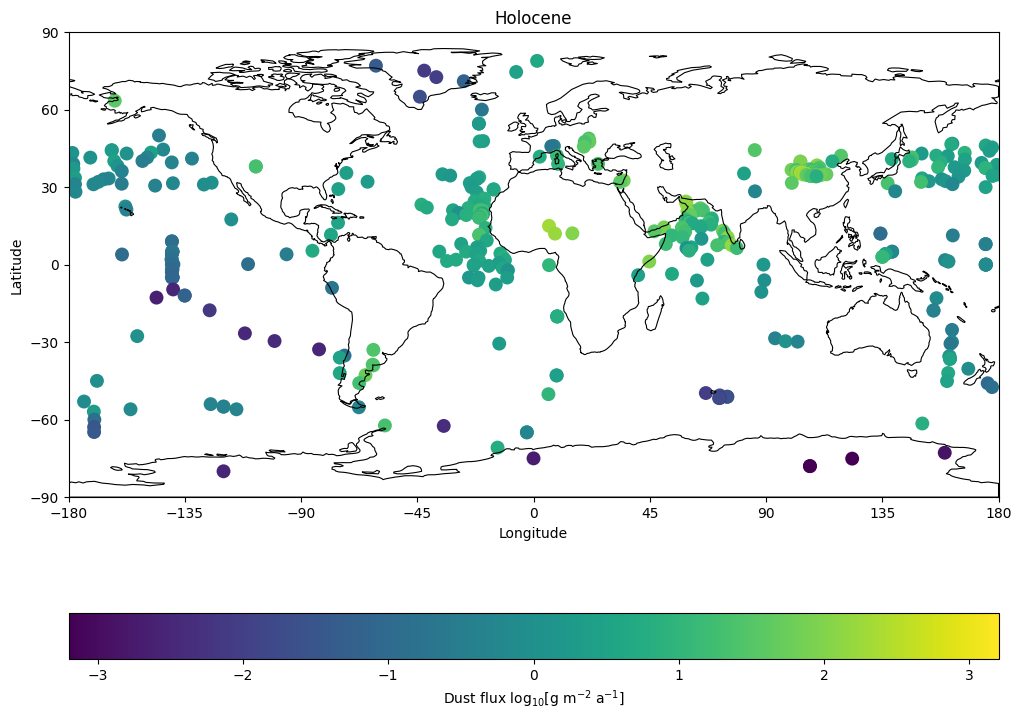

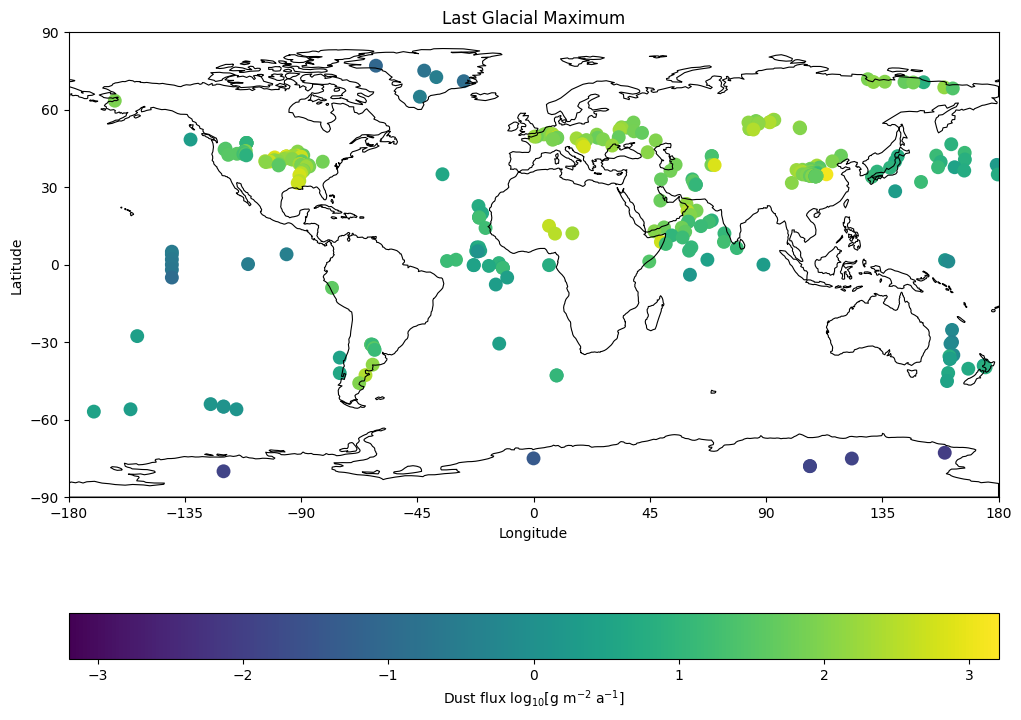

In [5]:
plot_dust_deposition_map(
    df=df_empirical_Holocene,
    title="Holocene",
    name_to_save="DATA_MAP_HOLOCENE",
    folder="empirical_data",
)

plot_dust_deposition_map(
    df=df_empirical_LGM,
    title="Last Glacial Maximum",
    name_to_save="DATA_MAP_LGM",
    folder="empirical_data",
)

### Configuración grid global

In [6]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([xx.reshape(-1), yy.reshape(-1)])
df_gpd_global_grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1])
)
df_global_grid = pd.DataFrame(
    {"lon": df_gpd_global_grid.geometry.x, "lat": df_gpd_global_grid.geometry.y}
)

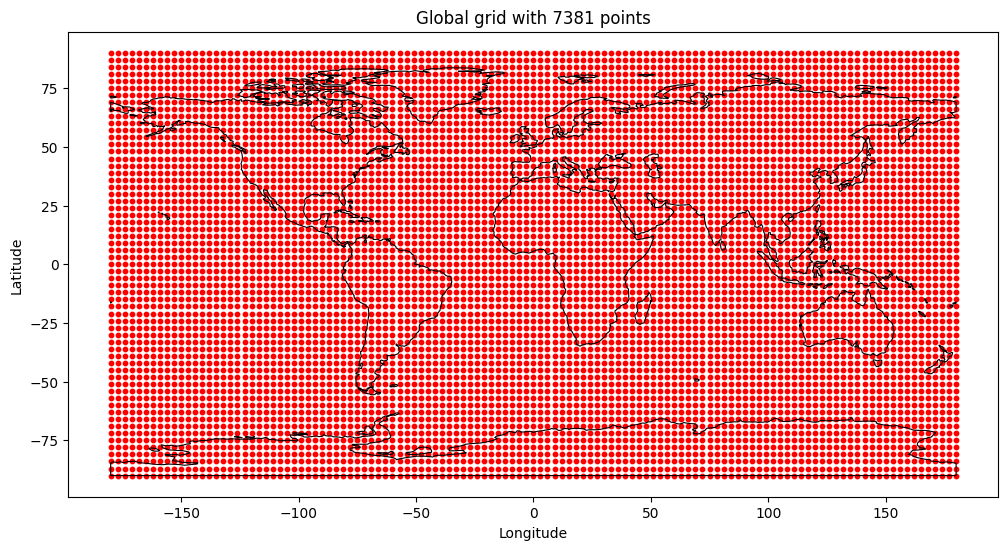

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
world_map.boundary.plot(ax=ax, color="black", linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color="red", markersize=10, marker="o")

ax.set(
    xlabel="Longitude",
    ylabel="Latitude",
    title=f"Global grid with {df_gpd_global_grid.shape[0]} points",
)
plt.show()

# Definición de las distancias

Nótese que la distancia euclidiana es entregada por el código de ejemplo, mientras que la distancia
geodésica es creada para esta tarea.

Nótese asimismo que, por las definiciones anteriores, `x[0]` representa la longitud y `x[1]` la latitud.

In [8]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2)
    return distance

Nótese, que dado el enunciado, la distancia geodésica es la siguiente:

$$
\text{Distancia geodésica} = R \cdot \arccos\left(\sin(\phi_1) \cdot \sin(\phi_2) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \cos(\lambda_2 - \lambda_1)\right)
$$

Donde:
- $ R $ es el radio de la Tierra.
- $ \phi_1 $ y $ \phi_2 $ son las latitudes de los dos puntos, respectivamente.
- $ \lambda_1 $ y $ \lambda_2 $ son las longitudes de los dos puntos, respectivamente.

In [9]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    # Radio de la Tierra en kilómetros (indagado en internet)
    R = 6371

    # Conversión de grados a radianes
    x_rad = np.radians(x)
    y_rad = np.radians(y)

    # Asignación de coordenadas
    lambda_1, phi_1 = x_rad
    lambda_2, phi_2 = y_rad

    # Fórmula de la distancia geodésica
    distance = R * np.arccos(
        np.sin(phi_1) * np.sin(phi_2)
        + np.cos(phi_1) * np.cos(phi_2) * np.cos(lambda_2 - lambda_1)
    )

    return distance

# Visualización de las distancias

### Método de vecinos cercanos (extraído del código base)

In [10]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """

    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean

    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))

    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]

    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)

    return estimation

In [11]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [12]:
# Inicialización.
estimations_holocene_geodesic = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geodesic = np.repeat(np.inf, len(df_global_grid))
estimations_holocene_euclidean = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_euclidean = np.repeat(np.inf, len(df_global_grid))

# Vecinos cercanos
for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])

    # Distance geodésica
    estimations_holocene_geodesic[index] = nearest_neighbour_estimation(
        df_empirical_Holocene, point_for_estimation, n_neighbours, dist="geodesic"
    )
    estimations_lgm_geodesic[index] = nearest_neighbour_estimation(
        df_empirical_LGM, point_for_estimation, n_neighbours, dist="geodesic"
    )

    # Distancia euclidiana
    estimations_holocene_euclidean[index] = nearest_neighbour_estimation(
        df_empirical_Holocene, point_for_estimation, n_neighbours, dist="euclidean"
    )
    estimations_lgm_euclidean[index] = nearest_neighbour_estimation(
        df_empirical_LGM, point_for_estimation, n_neighbours, dist="euclidean"
    )

# Asignación de las estimaciones a las columnas del DataFrame
df_global_grid["est_hol_geodesic"] = estimations_holocene_geodesic
df_global_grid["est_lgm_geodesic"] = estimations_lgm_geodesic
df_global_grid["est_hol_euclidean"] = estimations_holocene_euclidean
df_global_grid["est_lgm_euclidean"] = estimations_lgm_euclidean

### Mapas generados en base al método de vecinos cercanos

#### Mapa de la distancia euclidiana

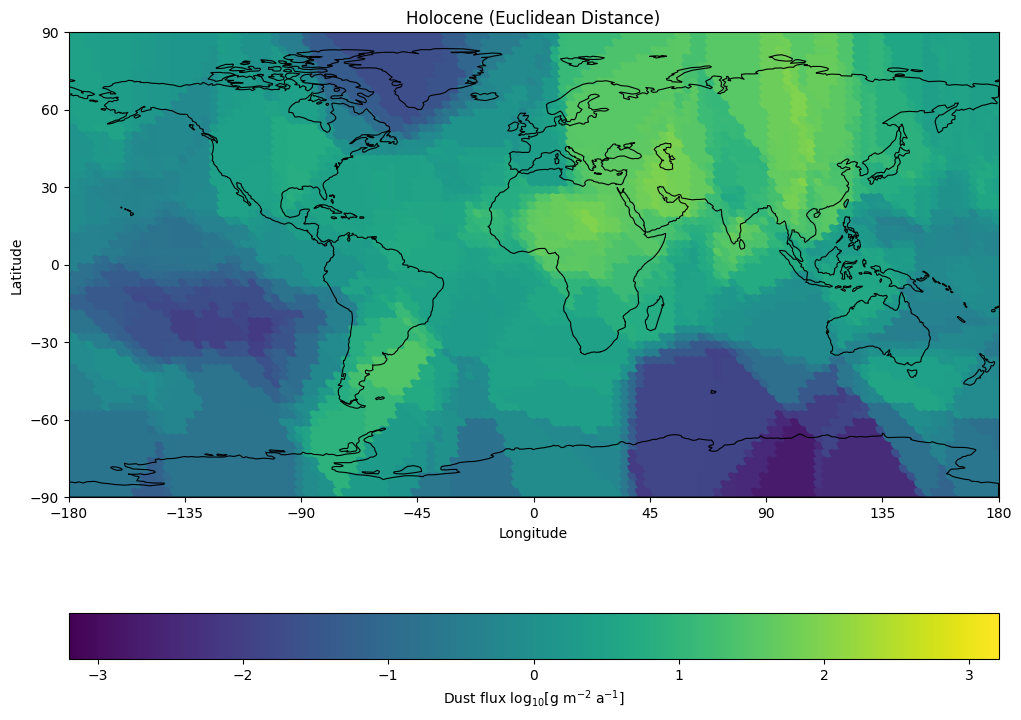

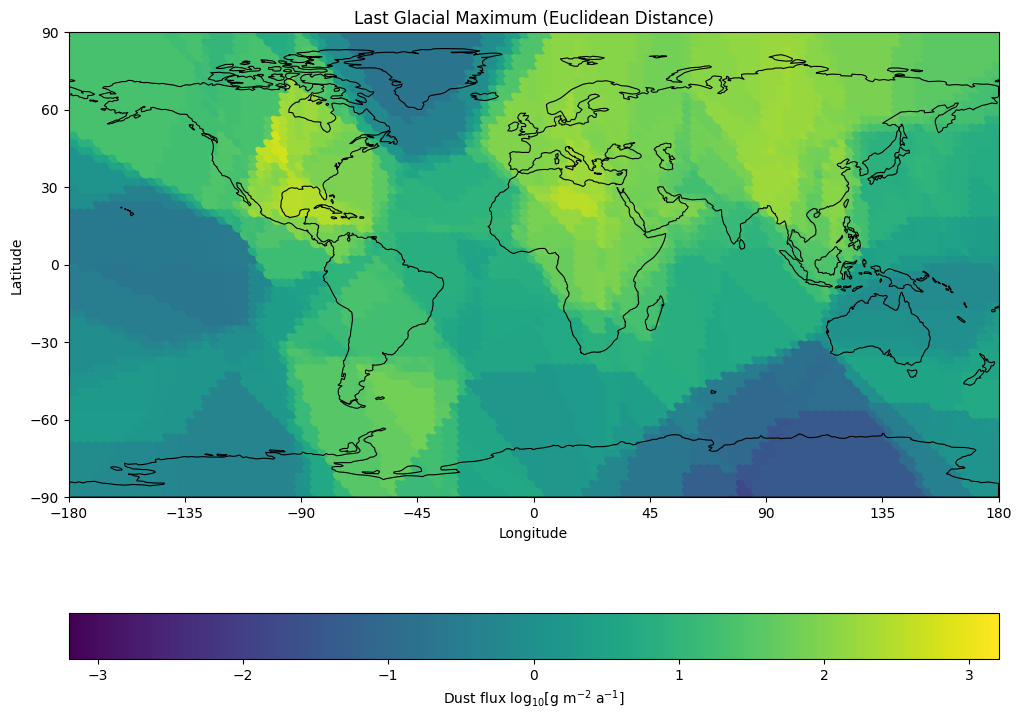

In [13]:
plot_dust_deposition_map(
    df=df_global_grid,
    title="Holocene (Euclidean Distance)",
    name_to_save="ESTIMATION_MAP_HOLOCENE_EUCLIDEAN_n=05",
    label_str="est_hol_euclidean",
    folder="euclidean_estimations",
)

plot_dust_deposition_map(
    df=df_global_grid,
    title="Last Glacial Maximum (Euclidean Distance)",
    name_to_save="ESTIMATION_MAP_LGM_EUCLIDEAN_n=05",
    label_str="est_lgm_euclidean",
    folder="euclidean_estimations",
)

#### Mapa de la distancia geodésica

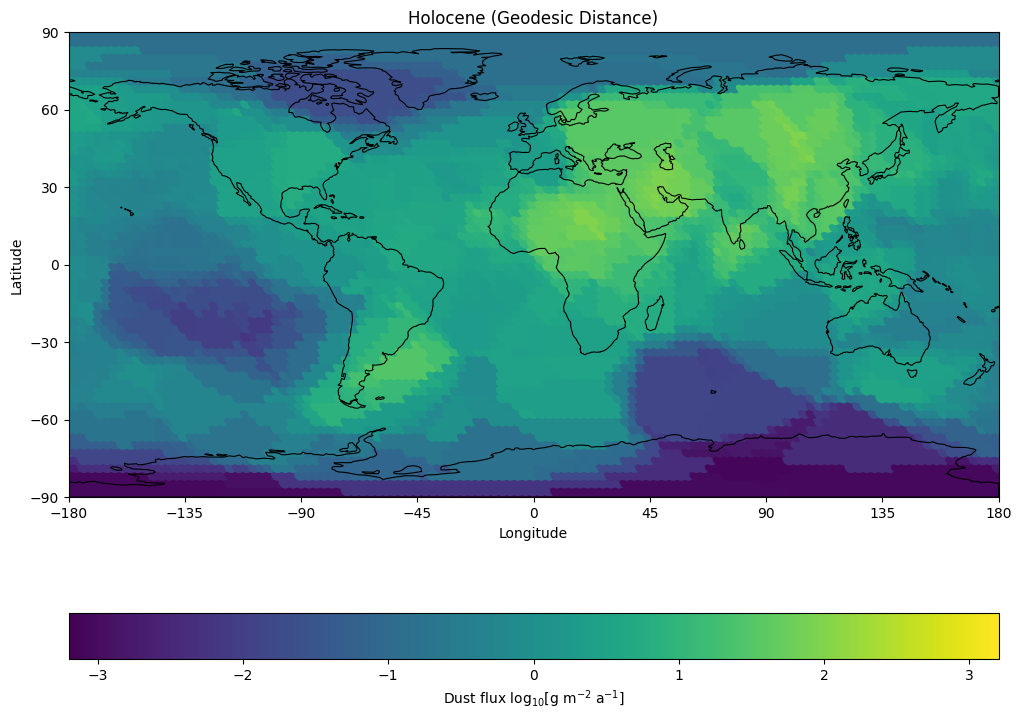

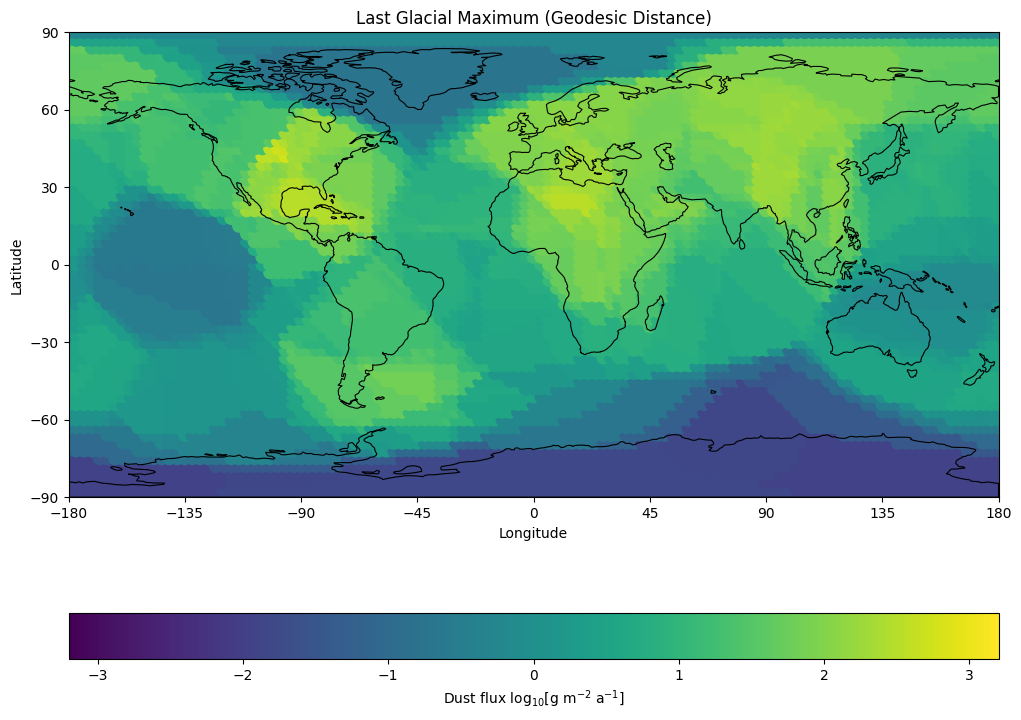

In [14]:
plot_dust_deposition_map(
    df=df_global_grid,
    title="Holocene (Geodesic Distance)",
    name_to_save="ESTIMATION_MAP_HOLOCENE_GEODESIC",
    label_str="est_hol_geodesic",
    folder="geodesic_estimations",
)

plot_dust_deposition_map(
    df=df_global_grid,
    title="Last Glacial Maximum (Geodesic Distance)",
    name_to_save="ESTIMATION_MAP_LGM_GEODESIC",
    label_str="est_lgm_geodesic",
    folder="geodesic_estimations",
)

Se observan diferencias en los mapas obtenidos, lo que implica que ciertamente las nociones de distancia son distintas.

# Diferencias entre las distancias

### Geodésica restada con euclideana

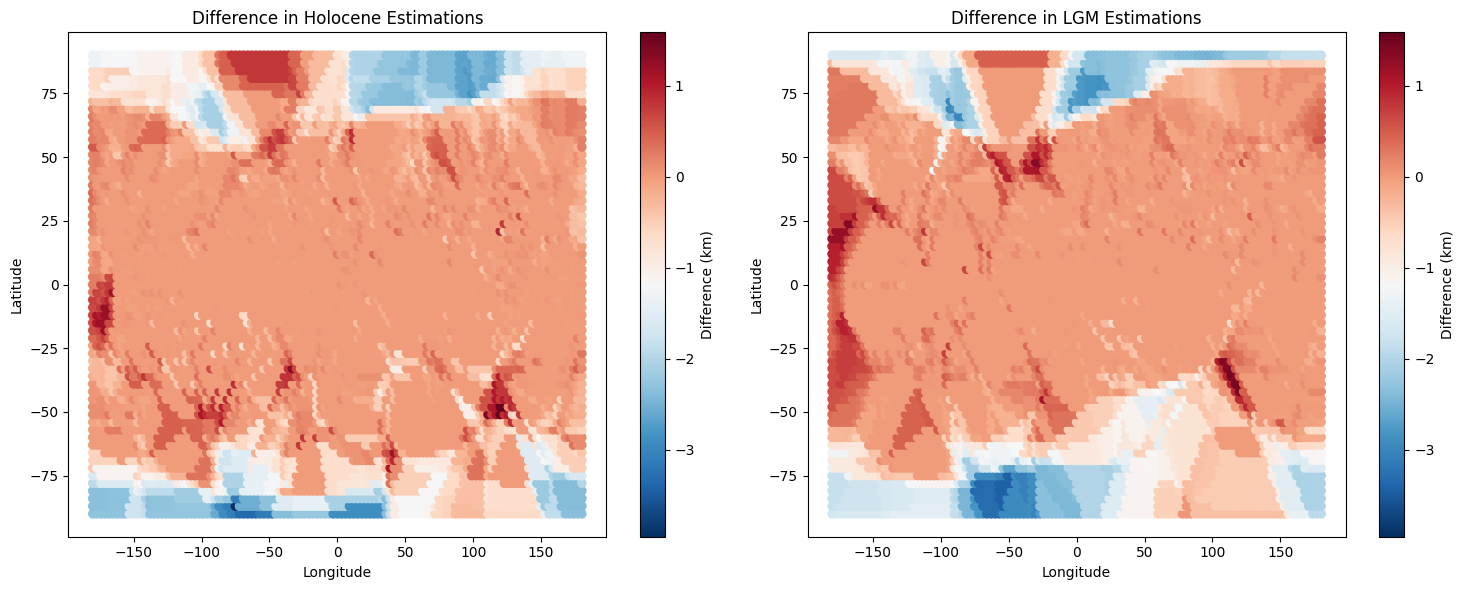

In [15]:
# Diferencia entre las estimaciones
difference_holocene = estimations_holocene_geodesic - estimations_holocene_euclidean
difference_lgm = estimations_lgm_geodesic - estimations_lgm_euclidean

# Asignación de las diferencias a las columnas del DataFrame
df_global_grid["difference_holocene"] = difference_holocene
df_global_grid["difference_lgm"] = difference_lgm

# Obtención de los valores mínimo y máximo para la escala de coloreado
vmin = min(difference_holocene.min(), difference_lgm.min())
vmax = max(difference_holocene.max(), difference_lgm.max())

# Creación de la figura y los ejes
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Caso de Holoceno
sc1 = axs[0].scatter(
    df_global_grid["lon"],
    df_global_grid["lat"],
    c=difference_holocene,
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
)
axs[0].set_title("Difference in Holocene Estimations")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
fig.colorbar(sc1, ax=axs[0], orientation="vertical", label="Difference (km)")

# Caso de LGM
sc2 = axs[1].scatter(
    df_global_grid["lon"],
    df_global_grid["lat"],
    c=difference_lgm,
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
)
axs[1].set_title("Difference in LGM Estimations")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")
fig.colorbar(sc2, ax=axs[1], orientation="vertical", label="Difference (km)")

plt.tight_layout()
os.makedirs("difference_maps")
save_path = os.path.join("difference_maps", "geodesic_minus_euclidean.png")
plt.savefig(save_path, dpi=300)
plt.show()

### Diferencia absoluta entre las distancias

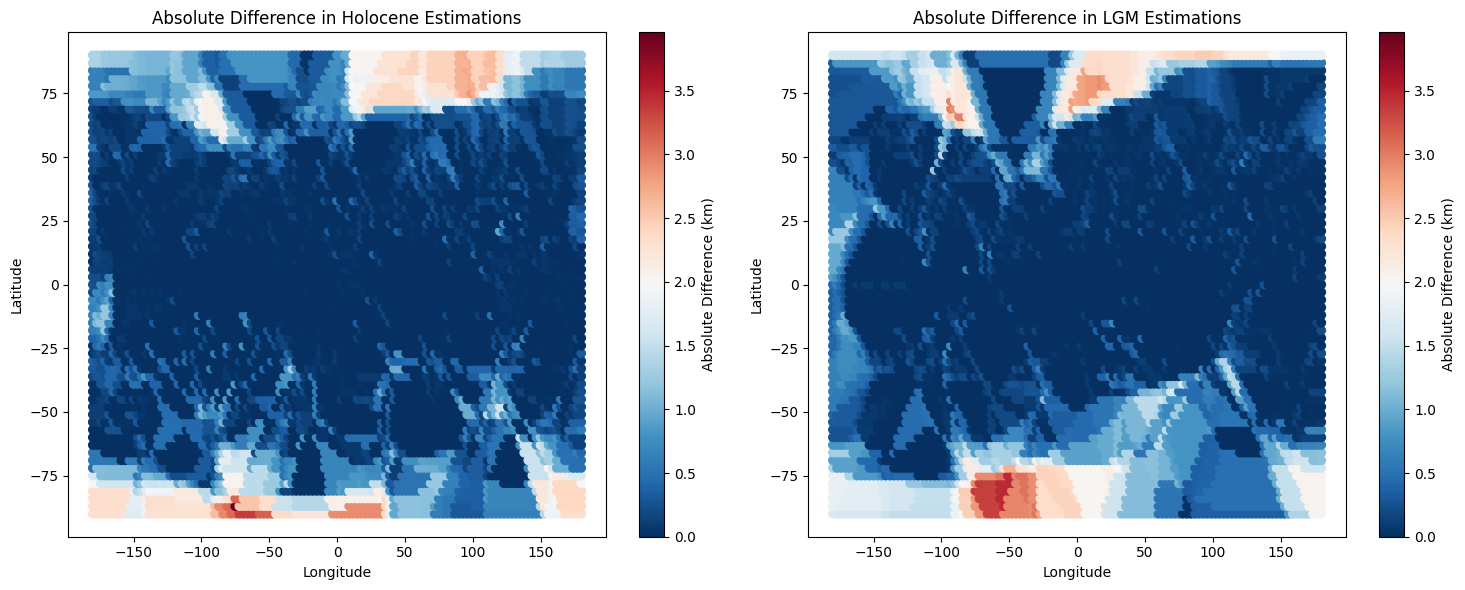

In [16]:
# Diferencia absoluta entre las estimaciones
abs_difference_holocene = np.abs(
    estimations_holocene_geodesic - estimations_holocene_euclidean
)
abs_difference_lgm = np.abs(estimations_lgm_geodesic - estimations_lgm_euclidean)

# Asignación de las diferencias a las columnas del DataFrame

df_global_grid["abs_difference_holocene"] = abs_difference_holocene
df_global_grid["abs_difference_lgm"] = abs_difference_lgm

# Obtención de los valores mínimo y máximo para la escala de coloreado
vmin = min(abs_difference_holocene.min(), abs_difference_lgm.min())
vmax = max(abs_difference_holocene.max(), abs_difference_lgm.max())

# Creación de la figura y los ejes
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Caso de Holoceno
sc1 = axs[0].scatter(
    df_global_grid["lon"],
    df_global_grid["lat"],
    c=abs_difference_holocene,
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
)
axs[0].set_title("Absolute Difference in Holocene Estimations")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
fig.colorbar(sc1, ax=axs[0], orientation="vertical", label="Absolute Difference (km)")

# Caso de LGM
sc2 = axs[1].scatter(
    df_global_grid["lon"],
    df_global_grid["lat"],
    c=abs_difference_lgm,
    cmap="RdBu_r",
    vmin=vmin,
    vmax=vmax,
)
axs[1].set_title("Absolute Difference in LGM Estimations")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")
fig.colorbar(sc2, ax=axs[1], orientation="vertical", label="Absolute Difference (km)")

plt.tight_layout()
save_path = os.path.join("difference_maps", "absolute_difference_maps.png")
plt.savefig(save_path, dpi=300)
plt.show()

# Discusión de los resultados obtenidos

### Código creado para la discusión

Nótese que el código siguiente intenta de ver cómo se comportan las prediciones con una diferente
cantidad de vecinos cercanos para los datos empíricos de la base de datos. 

Para ello, analiza la diferencia absoluta entre la predicción y el dato empírico, y luego suma
todas las diferencias para obtener un valor total. Las diferencias están en la misma escala que los
datos empíricos, por lo que se puede comparar directamente.

Se tiene que mientras menor sea la diferencia total, el modelo es más efectivo para los datos de la
base de datos. 

Aunque claro, como no se tienen todos los datos empíricos, una diferencia muy baja
tendería a hacer del modelo uno que padezca de *overfitting*. 

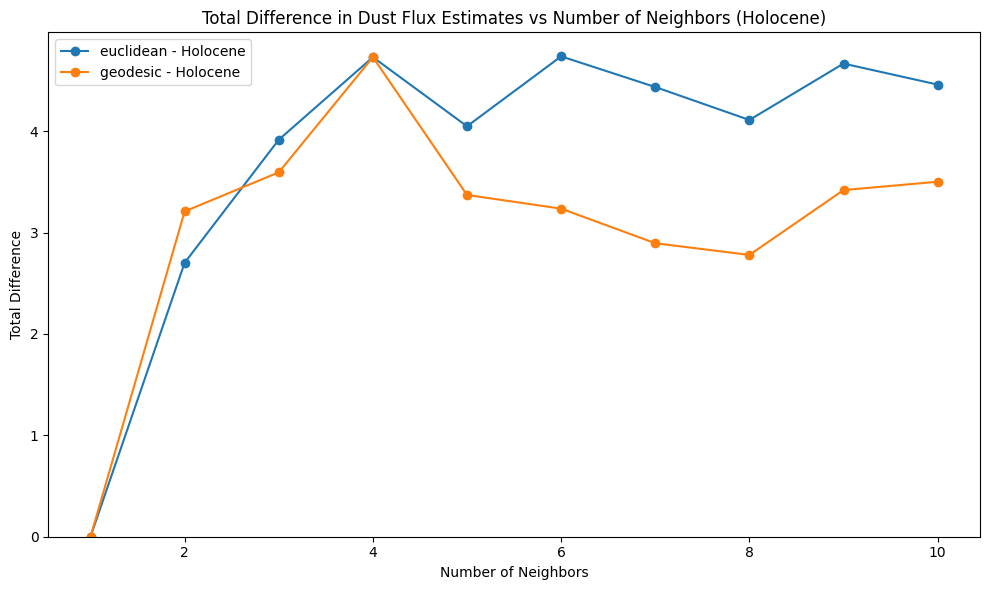

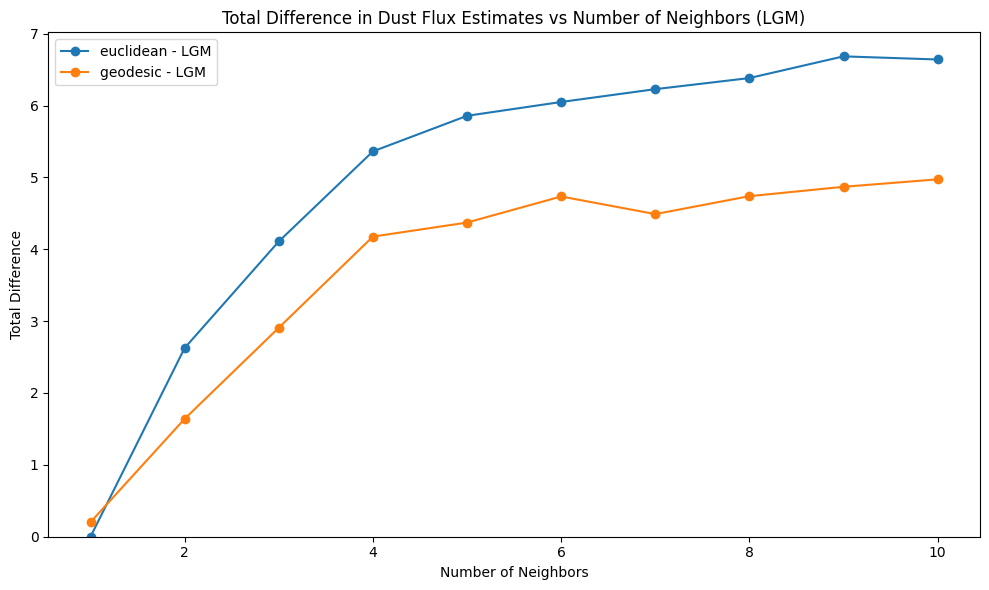

In [29]:
# Initialize results DataFrames

results_holocene = pd.DataFrame(
    columns=["n_neighbours", "dist_type", "total_difference"]
)
results_lgm = pd.DataFrame(columns=["n_neighbours", "dist_type", "total_difference"])

# Perform calculations for Holocene data
for n_neighbours in range(1, 11):
    for dist_type in ["euclidean", "geodesic"]:
        # Initialize array to store total difference
        total_difference_hol = 0

        # Iterate over each point in the global grid
        for index, row in df_global_grid.iterrows():
            point_for_estimation = (row["lon"], row["lat"])

            # Perform nearest neighbor estimation for Holocene data
            est_hol = nearest_neighbour_estimation(
                df_empirical_Holocene, point_for_estimation, n_neighbours, dist_type
            )

            # Check if the estimated value exists in the empirical data
            true_value = df_empirical_Holocene.loc[
                (df_empirical_Holocene["lon"] == point_for_estimation[0])
                & (df_empirical_Holocene["lat"] == point_for_estimation[1]),
                "log_dep",
            ].values
            # Check if true_value exists
            if len(true_value) > 0:
                # Calculate total difference for Holocene
                difference_hol = np.abs(est_hol - true_value[0])
                total_difference_hol += difference_hol

        # Store results in DataFrame for Holocene
        df_temp_hol = pd.DataFrame(
            {
                "n_neighbours": [n_neighbours],
                "dist_type": [dist_type],
                "total_difference": [total_difference_hol],
            }
        )
        results_holocene = pd.concat([results_holocene, df_temp_hol], ignore_index=True)

# Perform calculations for LGM data
for n_neighbours in range(1, 11):
    for dist_type in ["euclidean", "geodesic"]:
        # Initialize array to store total difference
        total_difference_lgm = 0

        # Iterate over each point in the global grid
        for index, row in df_global_grid.iterrows():
            point_for_estimation = (row["lon"], row["lat"])

            # Perform nearest neighbor estimation for LGM data
            est_lgm = nearest_neighbour_estimation(
                df_empirical_LGM, point_for_estimation, n_neighbours, dist_type
            )

            # Check if the estimated value exists in the empirical data
            true_value = df_empirical_LGM.loc[
                (df_empirical_LGM["lon"] == point_for_estimation[0])
                & (df_empirical_LGM["lat"] == point_for_estimation[1]),
                "log_dep",
            ].values
            # Check if true_value exists
            if len(true_value) > 0:
                # Calculate total difference for LGM
                difference_lgm = np.abs(est_lgm - true_value[0])
                total_difference_lgm += difference_lgm

        # Store results in DataFrame for LGM
        df_temp_lgm = pd.DataFrame(
            {
                "n_neighbours": [n_neighbours],
                "dist_type": [dist_type],
                "total_difference": [total_difference_lgm],
            }
        )
        results_lgm = pd.concat([results_lgm, df_temp_lgm], ignore_index=True)

# Visualize results for Holocene
fig, ax = plt.subplots(figsize=(10, 6))

# Total difference vs number of neighbors plot for Holocene
for dist_type in ["euclidean", "geodesic"]:
    df_dist_type = results_holocene[results_holocene["dist_type"] == dist_type]
    ax.plot(
        df_dist_type["n_neighbours"],
        df_dist_type["total_difference"],
        marker="o",
        label=f"{dist_type} - Holocene",
    )

ax.set_title(
    "Total Difference in Dust Flux Estimates vs Number of Neighbors (Holocene)"
)
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Total Difference")
ax.set_ylim(bottom=0)  # Ensure the y-axis starts from 0
ax.legend()

plt.tight_layout()
os.makedirs("neighbors_plots")
save_path = os.path.join(
    "neighbors_plots", "total_difference_vs_neighbors_holocene.png"
)
plt.savefig(save_path, dpi=300)
plt.show()

# Visualize results for LGM
fig, ax = plt.subplots(figsize=(10, 6))

# Total difference vs number of neighbors plot for LGM
for dist_type in ["euclidean", "geodesic"]:
    df_dist_type = results_lgm[results_lgm["dist_type"] == dist_type]
    ax.plot(
        df_dist_type["n_neighbours"],
        df_dist_type["total_difference"],
        marker="o",
        label=f"{dist_type} - LGM",
    )

ax.set_title("Total Difference in Dust Flux Estimates vs Number of Neighbors (LGM)")
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Total Difference")
ax.set_ylim(bottom=0)  # Ensure the y-axis starts from 0
ax.legend()

plt.tight_layout()
save_path = os.path.join("neighbors_plots", "total_difference_vs_neighbors_lgm.png")
plt.savefig(save_path, dpi=300)
plt.show()

Basándonos en los gráficos obtenidos, pude pensar en lo siguiente:

- Si se toma k = 1, se incurre en un riesgo grave de overfitting, lo que hace de este modelo uno
  que posiblemente no sea muy bueno de aplicar en la vida real. Esto, nótese claramente porque si
  se toma k = 1 en todos los casos se obtiene o bien una diferencia absoluta de 0 o muy cercana a
  0, lo cual no es bueno por el riesgo de overfitting ya mencionado.

- Con k = 2, la situación es similar a k = 1, por lo tanto, tampoco es una buena opción.

- Con k >= 3 tienden a ocurrir cosas más interesantes en los gráficos

- Con k=9 y k=10 no hay mucha diferencia en los gráficos, por lo que podría decirse que para k>=10 no
  debería existir mucha diferencia en los resultados obtenidos. 


  

***¿Qué modelo es el mejor?***

Esta interrogante no es fácil de responder, pero se tratará aquí de hacerlo. Para ello, se
considerará, con un método similar al del codo, en que punto la diferencia total se estabiliza o
vuelve notoriamente menor a sus cercanos (para k >= 3). Este criterio se aplicará para todas las
consideraciones expuestas posteriormente. 

Para el caso de los datos de Holoceno, con distancia euclidiana, el mejor k se encuentra en k=3.

Para el caso de los datos de Holoceno, con distancia geodésica, el mejor k se encuentra en k=8.

Para el caso de los datos de LGM, con distancia euclidiana, el mejor k se encuentra en k=4.

Para el caso de los datos de LGM, con distancia geodésica, el mejor k se encuentra en k=4.

***¿Distancia euclidiana o geodésica?***

Para los datos de Holoceno, la diferencia total es menor con la distancia geodésica, considerando el
modelo con el mejor k para ambas distancias.

Para los datos de LGM, la diferencia total es menor con la distancia geodésica, considerando el
modelo con el mejor k para ambas distancias.

Se concluye que tiene más sentido tomar la distancia geodésica para realizar este tipo de análisis,
ya que entrega mejores resultados, según lo observado en los gráficos y en los cálculos realizados.

In [35]:
# En base a lo anterior, guardar los "mejores modelos" para mi consideración.

# Holoceno geodésica k=8
# LGM geodésica k=4

estimations_holocene_best = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_best = np.repeat(np.inf, len(df_global_grid))

# Vecinos cercanos
for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])

    estimations_holocene_best[index] = nearest_neighbour_estimation(
        df_empirical_Holocene, point_for_estimation, k=8, dist="geodesic"
    )
    estimations_lgm_best[index] = nearest_neighbour_estimation(
        df_empirical_LGM, point_for_estimation, k=4, dist="geodesic"
    )

# Asignación de las mejores estimaciones a las columnas del DataFrame

df_global_grid["est_hol_best"] = estimations_holocene_best
df_global_grid["est_lgm_best"] = estimations_lgm_best

### Gráfica de los mejores modelos

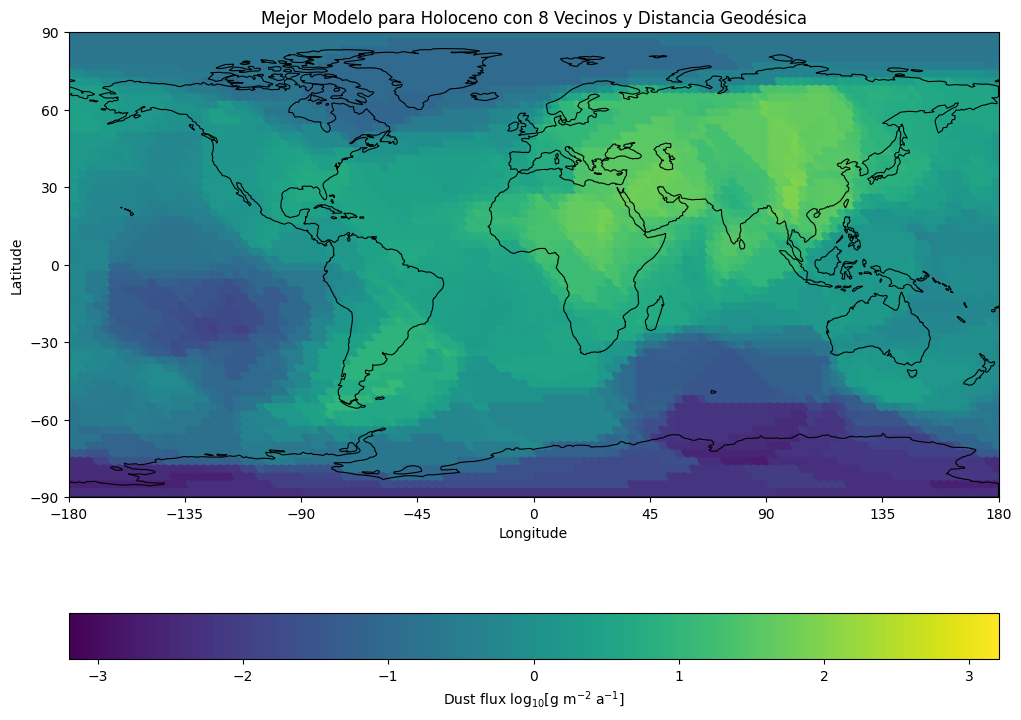

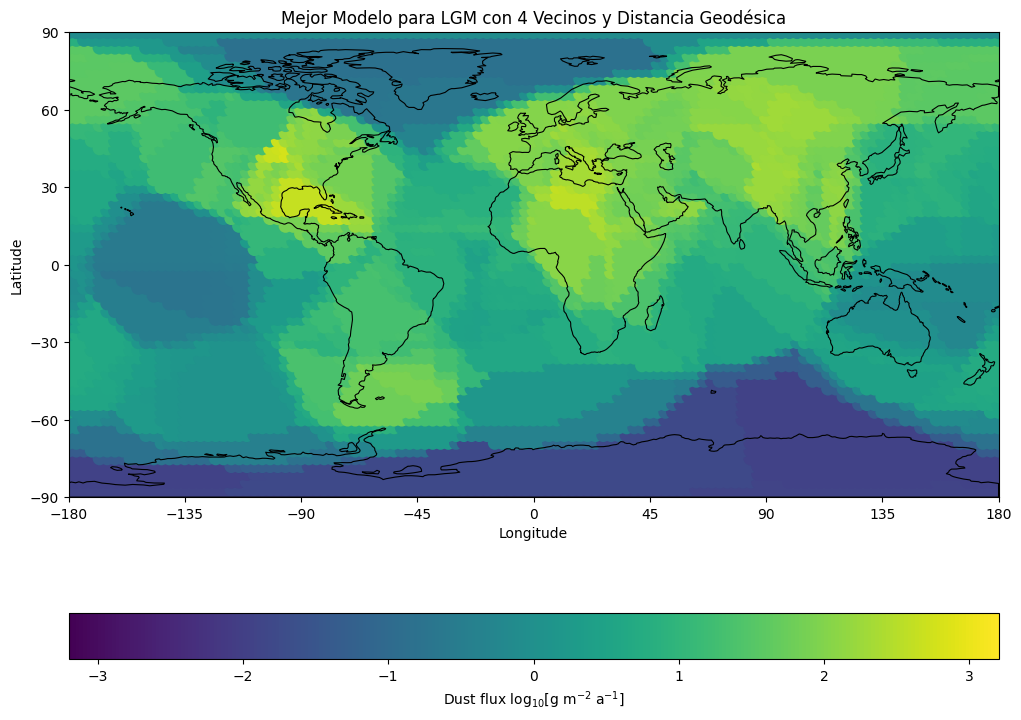

In [36]:
plot_dust_deposition_map(
    df=df_global_grid,
    title="Mejor Modelo para Holoceno con 8 Vecinos y Distancia Geodésica",
    name_to_save="best_model_holocene",
    label_str="est_hol_best",
    folder="best_models",
)

plot_dust_deposition_map(
    df=df_global_grid,
    title="Mejor Modelo para LGM con 4 Vecinos y Distancia Geodésica",
    name_to_save="best_model_lgm",
    label_str="est_lgm_best",
    folder="best_models",
)

### Discusión de los resultados

#### a) ¿Por qué las diferencias son más grandes en una parte que otra parte del mundo?

Esto se debe debido a que la distancia euclidiana considera que nuestro mundo es 2D. 

Al considerar un mundo 2D en una proyección sobre la Tierra, la métrica de distancia euclidiana no se ve muy afectada si uno considera latitudes cercanas a la 0.  En estas latitudes, la condición esférica de la Tierra no se deja notar tanto. En cambio, por los polos sí es ampliamente afectada, dado que ahí se refleja más fuertemente la curvatura innata de la Tierra, la cual no es considerada por la distancia euclidiana.

Resulta interesante considerar que el punto donde existe la mayor diferencia absoluta entre lo obtenido con las dos distancias es cercano a la latitud -90 y longitud -70; más o menos donde estaría ubicada la Antártica. Eso puede que se deba a una condición innata del lugar que afecte a las mediciones. 

Aunque en menor intensidad, también se detectan diferencias en las longitudes extremas del mapa, especialmente esto para el caso de datos de LGM, y en las latitudes extremas de -180.

[Fuente que explica la principal diferencia entre la distancia euclidiana y geodésica](https://dsp.stackexchange.com/questions/54826/what-is-different-between-euclidean-distance-and-the-geodesic-distance)

En la fuente de arriba, se entiende que las diferencias entre las distancias se dan porque la distancia geodésica logra capturar la esencia del movimiento “real” de la Tierra como una esfera, mientras que la distancia euclidiana no, y por eso en los puntos más extremos de las latitudes existe la mayor diferencia entre ambas métricas de distancia.


#### b) ¿Cuál método es más fidedigno en los polos sur y norte?

De lo analizado previamente (en los polos se refleja más la curvatura), y una inspección visual de las imágenes obtenidas, se comprueba que usar la distancia geodésica resulta en predicciones más fidedignas para ambos polos. Aunque las diferencias entre los modelos para el polo sur difieren mucho más en contraposición al polo norte.

Puede que esta diferencia para el polo sur y norte se deba a que los datos empíricos para el polo sur tienen bastante distribución por las longitudes, mientras que para el polo norte la mayoría de los datos se concentran en las cercanías de la longitud -45.

Esta última situación descrita ocurre para los datos de Holoceno tanto como para los datos de LGM. Se cree que esta situación altera enormemente los resultados obtenidos con el modelo.


#### c) ¿Cuál método es más fidedigno en longitud 180°?

Para la longitud 180, las dos métricas de distancia dan como resultados mapas muy similares. Solo
se aprecian diferencias notables en las latitudes extremas de la longitud 180, especialmente en la
latitud de -90, y en menor grado la latitud de 90. 

Como solo se aprecian diferencias notables en las latitudes extremas de la longitud 180, se deduce que la distancia geodésica es más fidedigna por lo analizado previamente en el inciso b. 

Esta vez ambas distancias predicen datos de manera muy similar, solo difiriendo muy ligeramente. 


#### d) ¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?

En primer lugar, se observa claramente que los puntos empíricos siguen una distribución distinta para Holoceno y LGM, y además los puntos en LGM tienden a ser más amarillos (lo que indica que existe más “*dust flux*”). Estas distinciones afectan ciertamente a los resultados obtenidos con las distancias, lo que genera mapas diferenciablemente notables entre LGM y Holoceno ya sea con cualquiera de las métricas de distancia.

Ahora, si se analizan las diferencias entre las estimaciones con las dos distancias, ya sea para Holoceno y LGM, no se ve tanta diferencia, salvo que para LGM tiende a existir una diferencia más notable entre las dos métricas. Esto último puede que se deba a que la variación en “*dust flux*” es mayor para LGM en comparación a Holoceno, lo que provoca que los errores provocados por la distancia euclidiana estén más acentuados y por ello mismo se tenga una mayor diferencia con la distancia geodésica. 

Aunque esta última tendencia no es generalizada para todo punto en el mapa realmente. Existen puntos que tienen una mayor diferencia para LGM, y otros para Holoceno. Lo que sí puede decirse con mayor generalidad entre LGM y Holoceno es que los puntos donde existe una diferencia notable en las métricas de distancia suelen ser los mismos, o zonas claramente similares.

También, si se inspecciona el gráfico de diferencia relativa (la cual acepta valores negativos), se
puede dar cuenta que, para LGM y Holoceno, las diferencias entre distancias suelen ser del mismo
color. Lo que indica que, si en un caso para euclidiana la diferencia es mayor en contraposición a
geodésica, esto se verá reflejado ya sea para LGM u Holoceno, y lo mismo en viceversa. 


#### e) ¿Cómo elegir el número de vecinos cercanos?

La mayoría de esta respuesta ya fue dada en el código anterior. Lo que se hizo para determinar el número óptimo de vecinos cercanos fue comparar las diferencias absolutas de las predicciones con los datos empíricos, y en base a un análisis del codo (*elbow method*) determinar bajo cuál k (número de vecinos) la diferencia se podría entender como la “mejor”, considerando que una diferencia de 0 (o muy cercana) con los datos de entrenamiento inducía a un modelo muy probablemente *overfitted*. 

Gracias a este análisis, se lograron obtener los llamados “mejores modelos”, donde se vio que era necesaria efectivamente una distancia geodésica para afrontar el problema de una mejor forma. 

Hay que considerar que diseñar la “eficiencia” del modelo no fue algo tan sencillo, y es difícil de valorar considerando la poca cantidad de datos empíricos que se tienen. 

A futuro, podría ser muy valioso obtener más datos empíricos para verificar la validez de los modelos generados en este archivo. Especialmente serían valiosos los datos empíricos de zonas en las cuales no se han obtenido puntos cercanos, para comprobar cuán buenas fueron las predicciones con KNN en esos puntos.  


# Comentarios finales

Nótese que se utilizó ChatGPT para mostrar la distancia geodésica en Latex.

También se utilizó para construir la función de distancia geodésica.

También se utilizó para adaptar el código de ejecución del algoritmo de vecinos cercanos.

ChatGPT también sirvió de apoyo para graficar la diferencia entre las distancias.

El código para ver la diferencia con diferentes k en KNN fue toda una odisea de crear, pero se
logró, con la ayuda de ChatGPT. 